In [4]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as patches

In [5]:
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Prep and Load Data

In [6]:
def prepare_data(task):

    if task == "FinanceBench":
        data = load_dataset("PatronusAI/financebench")["train"].to_pandas()
        data["page_num"] = data["evidence"].apply(lambda x: x[0]["evidence_page_num"])
        data["evidence"] = data["evidence"].apply(lambda x: x[0]["evidence_text"])
        return data
    
    elif task == "FinQA":
        dataset = load_dataset("ibm/finqa", trust_remote_code=True)
        data = pd.concat([dataset['train'].to_pandas(), dataset['validation'].to_pandas(), dataset['test'].to_pandas()])
        data.reset_index(drop=True, inplace=True)
        data = data[["id", "question", "answer", "gold_inds"]]
        data["Company"] = [row[0] for row in data.id.str.split("/")]
        data["Year"] = [row[1] for row in data.id.str.split("/")]
        data.id = data.id.map(lambda x: x.split("-")[0])
        return data

    elif task == "Table_VQA":
        def process_qa_id(qa_id):
            splitted = qa_id.split(".")[0]
            return splitted.split("_")[0] + "/" + splitted.split("_")[1] + "/" + splitted.split("_")[2] + "_" + splitted.split("_")[3] + ".pdf"

        data = load_dataset("terryoo/TableVQA-Bench")["fintabnetqa"].to_pandas()[["qa_id", "question", "gt", "text_html_table"]]
        data.qa_id = data.qa_id.apply(process_qa_id)
        data["Company"] = [row[0] for row in data.qa_id.str.split("/")]
        data["Year"] = [row[1] for row in data.qa_id.str.split("/")]
        data = data.rename(columns={"qa_id": "id", "gt": "answer", "text_html_table": "evidence"})
        return data

In [7]:
tasks = ["Table_VQA", "FinanceBench"]
input_types = ["text", "image", "hybrid"]
metrics = ["F1-Score", "BERTScore"]

In [8]:
data = []

for task in tasks:
    for input_type in input_types:
        for model_type in ["o1", "gpt-4o", "claude", "gemini-1.5-pro", "gemini-2.0-flash-exp",
                           "gemini-2.0-flash-thinking-exp","llama-3.2-90b-vision-instruct", "fireworks-qwen-2-vl-72b-instruct","deepseek-chat", "deepseek-r1"]:
            try:
                df_metrics = pd.read_csv(f"intermidiate_results/{task}/{input_type}/{model_type}_metrics.csv")
                
                entry = {
                    "Task": task,
                    "Input Type": input_type,
                    "Model Type": model_type,
                }
                
                for metric in metrics:
                    if metric in df_metrics.columns:
                        entry[metric] = df_metrics[metric].values
                    else:
                        entry[metric] = None
                
                data.append(entry)
            except Exception as e:
                entry = {
                    "Task": task,
                    "Input Type": input_type,
                    "Model Type": model_type,
                }
                
                for metric in metrics:
                    entry[metric] = None
                
                data.append(entry)

df_results = pd.DataFrame(data)
df_results.dropna(inplace=True)
df_results = df_results[(df_results["Model Type"] != "deepseek-chat") & (df_results["Model Type"] != "deepseek-r1")]

In [9]:
mean_df = df_results.dropna()
mean_df[metrics] = mean_df[metrics].applymap(np.mean).round(3)

std_df = df_results.dropna()
std_df[metrics] = std_df[metrics].applymap(np.std).round(3)

mean_df

,Task,Input Type,Model Type,F1-Score,BERTScore
0,Table_VQA,text,o1,0.428,0.668
1,Table_VQA,text,gpt-4o,0.421,0.688
2,Table_VQA,text,claude,0.459,0.697
3,Table_VQA,text,gemini-1.5-pro,0.369,0.585
4,Table_VQA,text,gemini-2.0-flash-exp,0.337,0.549
5,Table_VQA,text,gemini-2.0-flash-thinking-exp,0.357,0.659
6,Table_VQA,text,llama-3.2-90b-vision-instruct,0.357,0.670
7,Table_VQA,text,fireworks-qwen-2-vl-72b-instruct,0.382,0.673
10,Table_VQA,image,o1,0.764,0.848
11,Table_VQA,image,gpt-4o,0.781,0.854


In [10]:
model_order = ["O1", "Gemini 2.0 Thinking", "Claude 3.5 Sonnet", "Gpt-4o", "Gemini 2.0" , "Qwen 2 VL 72B", "LLAMA 3.2 90B", "Gemini 1.5 Pro"]

In [11]:
model_name_map = {
    "O1": "o1",
    "Gpt-4o": "gpt-4o",
    "Claude 3.5 Sonnet": "claude",
    "Gemini 2.0": "gemini-2.0-flash-exp",
    "Gemini 1.5 Pro": "gemini-1.5-pro",
    "Gemini 2.0 Thinking": "gemini-2.0-flash-thinking-exp",
    "LLAMA 3.2 90B": "llama-3.2-90b-vision-instruct",
    "Qwen 2 VL 72B": "fireworks-qwen-2-vl-72b-instruct",
    "Deepseek V3": "deepseek-chat",
    "Deepseek R1": "deepseek-r1",
}

model_name_map = {v:k for k,v in model_name_map.items()}

mean_df["Model Type"] = mean_df["Model Type"].replace(model_name_map)

for task in ["Table_VQA", "FinanceBench"]:
    task_mean_df = mean_df[mean_df["Task"] == task].drop("Task", axis=1)
    task_std_df = std_df[std_df["Task"] == task].drop("Task", axis=1)

    pivot_mean_df = task_mean_df.pivot(index='Model Type', columns='Input Type', values=metrics)
    pivot_std_df = task_std_df.pivot(index='Model Type', columns='Input Type', values=metrics)

    input_type_order = ['text', 'image', 'hybrid']
    pivot_mean_df = pivot_mean_df.reindex(columns=[(metric, input_type) for metric in metrics for input_type in input_type_order])
    pivot_std_df = pivot_std_df.reindex(columns=[(metric, input_type) for metric in metrics for input_type in input_type_order])

    pivot_mean_df = pivot_mean_df.sort_values(by=('F1-Score', 'hybrid'), ascending=True)
    pivot_std_df = pivot_std_df.sort_values(by=('F1-Score', 'hybrid'), ascending=True)

    pivot_df = pd.DataFrame(index=pivot_mean_df.index, columns=pivot_mean_df.columns)
    for column in pivot_mean_df.columns:
        pivot_df[column] = pivot_mean_df[column].map('{:.2f}'.format) + '±' + pivot_std_df[column].map('{:.2f}'.format)

    model_order_dict = {model: idx for idx, model in enumerate(model_order)}
    pivot_df = pivot_df.reindex(model_order)

    pivot_df.to_latex(f"{task}-modality_comparision.tex", float_format="%.2f", multicolumn=True)

pivot_df

F1-Score              BERTScore             
Input Type              text image hybrid      text image hybrid
Model Type                                                      
O1                       NaN   NaN    NaN       NaN   NaN    NaN
Gemini 2.0 Thinking      NaN   NaN    NaN       NaN   NaN    NaN
Claude 3.5 Sonnet        NaN   NaN    NaN       NaN   NaN    NaN
Gpt-4o                   NaN   NaN    NaN       NaN   NaN    NaN
Gemini 2.0               NaN   NaN    NaN       NaN   NaN    NaN
Qwen 2 VL 72B            NaN   NaN    NaN       NaN   NaN    NaN
LLAMA 3.2 90B            NaN   NaN    NaN       NaN   NaN    NaN
Gemini 1.5 Pro           NaN   NaN    NaN       NaN   NaN    NaN

In [52]:
from copy import deepcopy

std_df["Model Type"] = mean_df["Model Type"].replace(model_name_map)

for task in ["Table_VQA"]:
    task_df = mean_df[mean_df["Task"] == task].drop("Task", axis=1)
    pivot_df = task_df.pivot(index='Model Type', columns='Input Type', values=metrics)
    input_type_order = ['text', 'image', 'hybrid']
    pivot_df = task_df.pivot(index='Model Type', columns='Input Type', values=metrics)
    pivot_df = pivot_df.reindex(columns=[(metric, input_type) for metric in metrics for input_type in input_type_order])
    pivot_df = pivot_df.sort_values(by=('F1-Score', 'hybrid'), ascending=True)
    pivot_df.to_latex(f"{task}-modality_comparision.tex", float_format="%.3f", multicolumn=True)

table_vqa_pivot_df = deepcopy(pivot_df)

for task in ["FinanceBench"]:
    task_df = mean_df[mean_df["Task"] == task].drop("Task", axis=1)
    pivot_df = task_df.pivot(index='Model Type', columns='Input Type', values=metrics)
    input_type_order = ['text', 'image', 'hybrid']
    pivot_df = task_df.pivot(index='Model Type', columns='Input Type', values=metrics)
    pivot_df = pivot_df.reindex(columns=[(metric, input_type) for metric in metrics for input_type in input_type_order])
    pivot_df = pivot_df.sort_values(by=('F1-Score', 'hybrid'), ascending=True)
    pivot_df.to_latex(f"{task}-modality_comparision.tex", float_format="%.3f", multicolumn=True)

In [53]:
financebench_pivot_df = deepcopy(pivot_df)

pivot_df['F1-Score-Text-Diff'] = pivot_df[('F1-Score', 'hybrid')] - pivot_df[('F1-Score', 'text')]
pivot_df['F1-Score-Vision-Diff'] = pivot_df[('F1-Score', 'hybrid')] - pivot_df[('F1-Score', 'image')]
pivot_df = pivot_df.sort_values('F1-Score-Vision-Diff', ascending=False)
pivot_df

F1-Score               BERTScore                \
Input Type              text  image hybrid      text  image hybrid   
Model Type                                                           
Gemini 2.0 Thinking    0.250  0.162  0.253     0.540  0.474  0.552   
Claude 3.5 Sonnet      0.272  0.163  0.249     0.561  0.466  0.564   
LLAMA 3.2 90B          0.196  0.108  0.187     0.539  0.502  0.525   
Gemini 2.0             0.231  0.160  0.236     0.510  0.503  0.549   
O1                     0.247  0.185  0.260     0.543  0.493  0.563   
Gpt-4o                 0.249  0.167  0.241     0.544  0.490  0.573   
Gemini 1.5 Pro         0.173  0.114  0.173     0.543  0.531  0.558   
Qwen 2 VL 72B          0.173  0.165  0.205     0.525  0.480  0.553   

                    F1-Score-Text-Diff F1-Score-Vision-Diff  
Input Type                                                   
Model Type                                                   
Gemini 2.0 Thinking              0.003                0.091  
Claude 3.5 Sonnet               -0.023                0.086  
LLAMA 3.2 90B                   -0.009                0.079  
Gemini 2.0                       0.005                0.076  
O1                               0.013                0.075  
Gpt-4o                          -0.008                0.074  
Gemini 1.5 Pro                   0.000                0.059  
Qwen 2 VL 72B                    0.032                0.040

In [56]:
table_vqa_pivot_df.sort_values(by=('F1-Score', 'hybrid'), ascending=False)

table_vqa_pivot_df['F1-Score-Text-Diff'] = table_vqa_pivot_df[('F1-Score', 'hybrid')] - table_vqa_pivot_df[('F1-Score', 'text')]
table_vqa_pivot_df['F1-Score-Vision-Diff'] = table_vqa_pivot_df[('F1-Score', 'hybrid')] - table_vqa_pivot_df[('F1-Score', 'image')]
table_vqa_pivot_df = table_vqa_pivot_df.sort_values('F1-Score-Vision-Diff', ascending=False)
table_vqa_pivot_df

F1-Score               BERTScore                \
Input Type              text  image hybrid      text  image hybrid   
Model Type                                                           
Gemini 1.5 Pro         0.369  0.379  0.532     0.585  0.709  0.714   
LLAMA 3.2 90B          0.357  0.404  0.471     0.670  0.729  0.739   
Claude 3.5 Sonnet      0.459  0.812  0.829     0.697  0.866  0.875   
Gemini 2.0 Thinking    0.357  0.680  0.687     0.659  0.840  0.838   
Gpt-4o                 0.421  0.781  0.783     0.688  0.854  0.858   
Gemini 2.0             0.337  0.563  0.552     0.549  0.698  0.689   
O1                     0.428  0.764  0.744     0.668  0.848  0.840   
Qwen 2 VL 72B          0.382  0.823  0.777     0.673  0.866  0.858   

                    F1-Score-Text-Diff F1-Score-Vision-Diff  
Input Type                                                   
Model Type                                                   
Gemini 1.5 Pro                   0.163                0.153  
LLAMA 3.2 90B                    0.114                0.067  
Claude 3.5 Sonnet                0.370                0.017  
Gemini 2.0 Thinking              0.330                0.007  
Gpt-4o                           0.362                0.002  
Gemini 2.0                       0.215               -0.011  
O1                               0.316               -0.020  
Qwen 2 VL 72B                    0.395               -0.046

In [13]:
avg_scores = []

for task in tasks:
    task_data = mean_df[mean_df.Task == task]
    
    for input_type in input_types:
        filtered_data = task_data[task_data['Input Type'] == input_type][metrics]
        means = filtered_data.mean()
        stds = filtered_data.std()
        
        # Combine mean and std in format "mean±std"
        combined_scores = pd.Series({metric: f"{means[metric]:.3f}±{stds[metric]:.3f}" for metric in metrics})
        scores = pd.DataFrame(combined_scores).T
        scores.insert(0, 'Task', task)
        scores.insert(1, 'Input Type', input_type)
        avg_scores.append(scores)

avg_df = pd.concat(avg_scores)

# Create MultiIndex columns with task and metric
columns = pd.MultiIndex.from_product([tasks, metrics], names=['Task', 'Metric'])
display_df = pd.DataFrame(index=input_types, columns=columns)

# Fill the DataFrame with values
for task in tasks:
    task_data = avg_df[avg_df.Task == task].set_index('Input Type')
    for metric in metrics:
        display_df[task, metric] = task_data[metric]

display_df.to_latex("modality_average_scores.tex", escape=False, multicolumn=True)
display_df

Task      Table_VQA              FinanceBench             
Metric     F1-Score    BERTScore     F1-Score    BERTScore
text    0.389±0.043  0.649±0.053  0.224±0.038  0.538±0.015
image   0.651±0.181  0.801±0.075  0.153±0.027  0.492±0.020
hybrid  0.672±0.135  0.801±0.074  0.226±0.033  0.555±0.014

In [14]:
avg_scores = []

for task in tasks:
    task_data = mean_df[mean_df.Task == task]
    
    for input_type in input_types:
        scores = task_data[task_data['Input Type'] == input_type][metrics].max()
        scores = pd.DataFrame(scores).T
        scores.insert(0, 'Task', task)
        scores.insert(1, 'Input Type', input_type)
        avg_scores.append(scores)

avg_df = pd.concat(avg_scores)

# Create MultiIndex columns with task and metric
columns = pd.MultiIndex.from_product([tasks, metrics], names=['Task', 'Metric'])
display_df = pd.DataFrame(index=input_types, columns=columns)

# Fill the DataFrame with values
for task in tasks:
    task_data = avg_df[avg_df.Task == task].set_index('Input Type')
    for metric in metrics:
        display_df[task, metric] = task_data[metric]

display_df = display_df.round(3)
display_df.to_latex("modality_max_scores.tex", float_format="%.3f", multicolumn=True)
display_df

Task   Table_VQA           FinanceBench          
Metric  F1-Score BERTScore     F1-Score BERTScore
text       0.459     0.697        0.272     0.561
image      0.823     0.866        0.185     0.531
hybrid     0.829     0.875        0.260     0.573

# Visualize

In [15]:
colors = {
    "o1" : "cyan",
    "gpt-4o": "blue", 
    "claude": "red", 
    "gemini-2.0-flash-exp": "green", 
    "gemini-1.5-pro": "purple", 
    "gemini-2.0-flash-thinking-exp": "orange",
    "llama-3.2-90b-vision-instruct": "brown",
    "fireworks-qwen-2-vl-72b-instruct": "yellow",
}
legend_labels = model_order

label_to_color_key = {
    "O1" : "o1",
    "Gpt-4o": "gpt-4o",
    "Claude 3.5 Sonnet": "claude",
    "Gemini 2.0": "gemini-2.0-flash-exp",
    "Gemini 1.5 Pro": "gemini-1.5-pro",
    "Gemini 2.0 Thinking": "gemini-2.0-flash-thinking-exp",
    "LLAMA 3.2 90B": "llama-3.2-90b-vision-instruct",
    "Qwen 2 VL 72B": "fireworks-qwen-2-vl-72b-instruct",
}

In [16]:
model_order = ["o1", "gemini-2.0-flash-thinking-exp", "claude", "gpt-4o", "gemini-2.0-flash-exp", "fireworks-qwen-2-vl-72b-instruct", "llama-3.2-90b-vision-instruct", "gemini-1.5-pro"]

In [17]:
def plot_metrics(task,figure_size=(12, 8), dpi=300):

    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.edgecolor'] = '#333333'
    
    summary_data = []
    for input_type in input_types:
        for metric in metrics:
            df_filtered = df_results[(df_results["Task"] == task) & 
                                   (df_results["Input Type"] == input_type)]
            
            for model_type in model_order:
                df_model = df_filtered[df_filtered["Model Type"] == model_type]
                values = [item for sublist in df_model[metric].dropna().values 
                         for item in sublist]

                if values:  
                    mean_value = pd.Series(values).mean()
                    std_value = pd.Series(values).std()
                    summary_data.append({
                        "Input Type": input_type,
                        "Metric": metric,
                        "Model Type": model_type,
                        "Mean": mean_value,
                        "Std": std_value
                    })

    summary_df = pd.DataFrame(summary_data)

    # Create figure with specific size and DPI for publication
    g = sns.catplot(
        data=summary_df,
        x="Model Type",
        y="Mean",
        col="Input Type",
        row="Metric",
        kind="bar",
        height=figure_size[1]/len(metrics),
        aspect=figure_size[0]/(figure_size[1]/len(metrics))/len(input_types),
        palette=colors,
        errorbar=None
    )
    
    # Enhance the appearance of each subplot
    for idx, ax in enumerate(g.axes.flat):
        row_idx = idx // len(input_types)
        col_idx = idx % len(input_types)
        current_metric = metrics[row_idx]
        current_input_type = input_types[col_idx]

        current_data = summary_df[
            (summary_df["Metric"] == current_metric) &
            (summary_df["Input Type"] == current_input_type)
        ]

        # Replace default bars with rounded rectangles
        for bar, (_, row) in zip(ax.patches, current_data.iterrows()):
            mean = row["Mean"]
            std = row["Std"]

            # Create rounded rectangle
            bar_width = bar.get_width() * 0.8
            bar_x = bar.get_x() + (bar.get_width() - bar_width) / 2
            rounded_rect = patches.FancyBboxPatch(
                (bar_x, 0),
                bar_width,
                bar.get_height(),
                boxstyle="round,pad=0.02",
                linewidth=1,
                edgecolor='#333333',
                facecolor=bar.get_facecolor(),
                alpha=1
            )
            ax.add_patch(rounded_rect)
            bar.remove()

            # Add error bars
            ax.errorbar(
                x=bar_x + bar_width/2,
                y=mean,
                yerr=std,
                color='#333333',
                capsize=3,
                capthick=1,
                linewidth=1,
                zorder=3
            )

            # Add value labels
            if mean >= 0.0:  # Only show labels for values >= 0.1
                ax.annotate(
                    f"{mean:.2f}",
                    xy=(bar_x + bar_width/2, mean + std + 0.01),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    color="#000000",
                    weight='bold'
                )

        # Customize axes
        ax.grid(True, axis='y', linestyle=' ', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=10)
        
    # Customize titles and labels
    g.set_titles("{col_name}", fontsize=10, weight='bold', y=2.0)
    for ax in g.axes.flat:
        if ax.get_title():
            ax.set_title(ax.get_title().upper(), fontsize=12, weight='bold')
            ax.title.set_position([0.5, 1.1])
            
    # Add metric labels
    for ax, metric in zip(g.axes[:, 0], metrics):
        ax.set_ylabel(metric, fontsize=11, weight='bold')
        ax.set_xticklabels([])
        
    # Create legend
    handles = [plt.Rectangle((0, 0), 1, 1, facecolor=colors[label_to_color_key[label]], 
                           edgecolor='#333333', linewidth=1) 

               for label in legend_labels]
    legend = g.fig.legend(
        handles,
        legend_labels,
        title="Model Type",
        fontsize=10,
        title_fontsize=11,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.08),
        ncol=len(legend_labels),
        frameon=True,
        edgecolor='#333333'
    )
    legend.set_title("Model Type", prop={"weight": "bold", "size": 11})

    # Adjust layout
    plt.tight_layout()
    
    # Save with high DPI
    plt.savefig(f'metrics_{task}.pdf', dpi=dpi, bbox_inches='tight', format='pdf')
    plt.savefig(f'metrics_{task}.png', dpi=dpi, bbox_inches='tight', format='png')
    plt.close()

    return g

In [24]:
def plot_metrics(task, figure_size=(30, 3), dpi=300):
    sns.set_theme(style="white", palette=sns.color_palette("husl", n_colors=len(input_types)))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['axes.edgecolor'] = '#333333'

    summary_data = []
    for input_type in input_types:
        for metric in metrics:
            df_filtered = df_results[(df_results["Task"] == task) &
                                      (df_results["Input Type"] == input_type)]
            for model_type in model_order:
                df_model = df_filtered[df_filtered["Model Type"] == model_type]
                values = [item for sublist in df_model[metric].dropna().values
                          for item in sublist]

                if values:
                    summary_data.append({
                        "Input Type": input_type,
                        "Metric": metric,
                        "Model Type": model_type,
                        "Values": values
                    })

    summary_df = pd.DataFrame(summary_data)

    # Transform the data for boxplot compatibility
    melted_df = summary_df.explode("Values")

    # Prepare subplots
    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=figure_size, dpi=dpi, sharey=True)

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        metric_data = melted_df[melted_df["Metric"] == metric]

        # Create the boxplot
        sns.boxplot(
            data=metric_data,
            x="Model Type",
            y="Values",
            hue="Input Type",
            dodge=True,
            linewidth=1.5,
            ax=ax
        )

        # Adjust opacity of the boxes
        for patch in ax.patches:
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, 0.9))  # Set opacity to 90%

        ax.set_title(metric, fontsize=21, weight='bold', pad=15)
        if idx == 0:
            ax.set_ylabel("Values", fontsize=12, weight='bold')
        else:
            ax.set_ylabel("")
        ax.set_yticklabels([0, 0.0, 0.5, 1.0], fontsize=15, weight='bold')
        ax.legend_.remove()  

    handles, labels = axes[-1].get_legend_handles_labels()
    labels = [i.upper() for i in labels]
    
    fig.legend(
        handles,
        labels,
        title=" ",
        title_fontsize=10,
        fontsize=20,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.3),
        ncol=len(input_types),
        frameon=False,
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(f"boxplot_metrics_subplots_{task}.pdf", dpi=dpi, bbox_inches='tight', format='pdf')
    plt.savefig(f"boxplot_metrics_subplots_{task}.png", dpi=dpi, bbox_inches='tight', format='png')
    plt.close()

    return fig

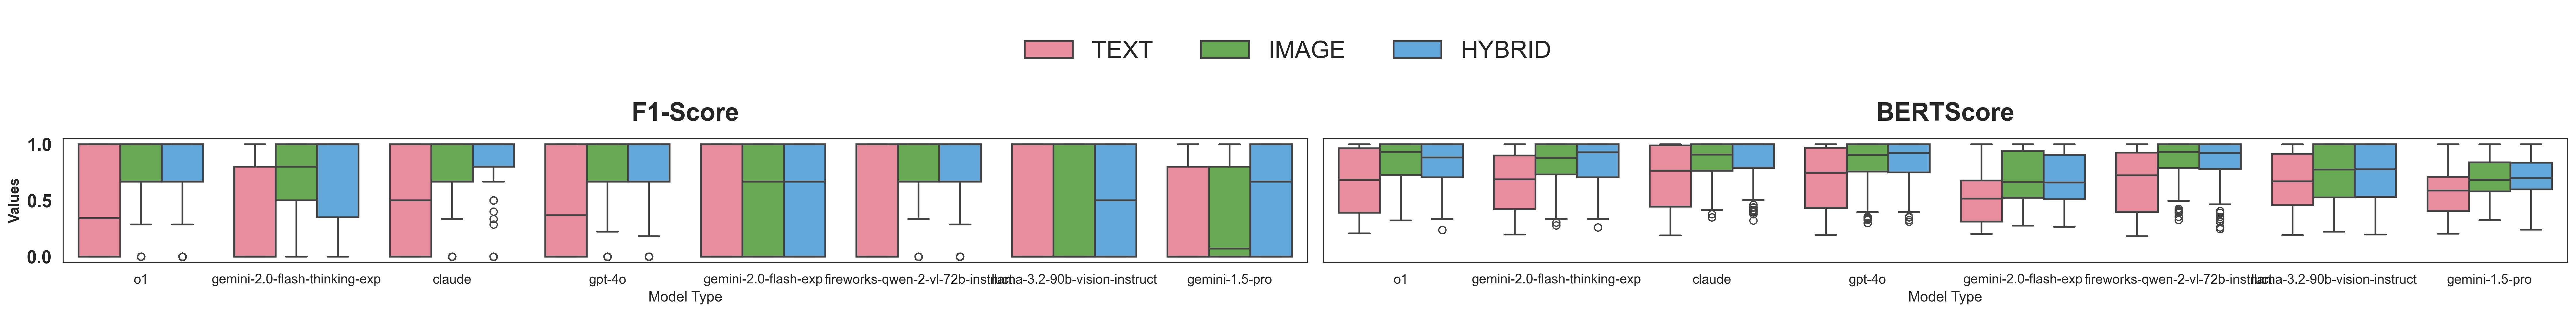

In [25]:
plot_metrics("Table_VQA")

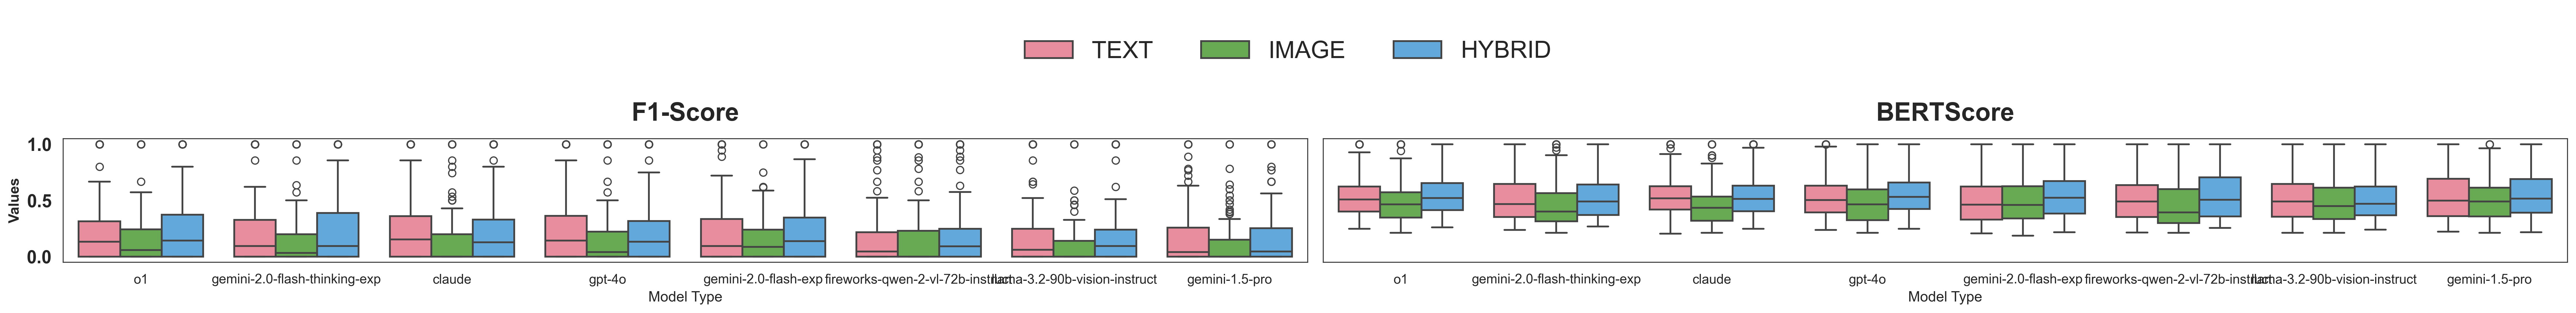

In [26]:
plot_metrics("FinanceBench")

# Significance Tests

In [21]:
import os 
import sys 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from significance_tests import compare_models

In [22]:
temp = df_results

In [23]:
sigificance_results = pd.DataFrame(columns=[
    "Metric", "Group Test Used", "Group Significance Value", 
    "Used Test", "Best Method", "Compared Method", 
    "Significance Value", "Significant"
])

for task in tasks:
    for inp_type in input_types:
        df = temp[(temp.Task == task) & (temp["Input Type"] == inp_type)][["Model Type"] + metrics].set_index("Model Type")
        
        empty_row = pd.DataFrame([{
            "Metric": f"{task}-{inp_type}",
            "Group Test Used": "",
            "Group Significance Value": "",
            "Used Test": "",
            "Best Method": "",
            "Compared Method": "",
            "Significance Value": "",
            "Significant": ""
        }])
        sigificance_results = pd.concat([sigificance_results, empty_row], ignore_index=True)
        
        comparison_results = compare_models(df)
        sigificance_results = pd.concat([sigificance_results, comparison_results], ignore_index=True)

2025-01-24 12:06:34,213 - INFO - Best model for F1-Score: claude
2025-01-24 12:06:34,214 - INFO - Best model for BERTScore: claude
2025-01-24 12:06:34,214 - INFO - Processing metric: F1-Score
2025-01-24 12:06:34,216 - INFO - Normality test for o1 on F1-Score: not normal
2025-01-24 12:06:34,220 - INFO - Normality test for gpt-4o on F1-Score: not normal
2025-01-24 12:06:34,222 - INFO - Normality test for claude on F1-Score: not normal
2025-01-24 12:06:34,223 - INFO - Normality test for gemini-1.5-pro on F1-Score: not normal
2025-01-24 12:06:34,224 - INFO - Normality test for gemini-2.0-flash-exp on F1-Score: not normal
2025-01-24 12:06:34,225 - INFO - Normality test for gemini-2.0-flash-thinking-exp on F1-Score: not normal
2025-01-24 12:06:34,227 - INFO - Normality test for llama-3.2-90b-vision-instruct on F1-Score: not normal
2025-01-24 12:06:34,227 - INFO - Normality test for fireworks-qwen-2-vl-72b-instruct on F1-Score: not normal


ValueError: Unequal N in friedmanchisquare.  Aborting.

In [ ]:
sigificance_results.to_excel("model_significance_results.xlsx")
sigificance_results

In [ ]:
sigificance_results = pd.DataFrame(columns=[
    "Metric", "Group Test Used", "Group Significance Value", 
    "Used Test", "Best Method", "Compared Method", 
    "Significance Value", "Significant"
])


best_models = {}

for task in tasks:
    for inp_type in input_types:
        for metric in metrics:
            df = temp[(temp.Task == task) & (temp["Input Type"] == inp_type)][["Model Type", metric]].set_index("Model Type")
            df = df.applymap(lambda x: np.mean(x))
            best_models[f"{task}-{inp_type}-{metric}"] = str(df.idxmax().values[0])
            
sigificance_results = pd.DataFrame(columns=[
    "Metric", "Group Test Used", "Group Significance Value", 
    "Used Test", "Best Method", "Compared Method", 
    "Significance Value", "Significant"
])

for task in tasks:
    for metric in metrics:
        
        modality_df = pd.DataFrame()

        for inp_type in input_types:
            best = temp[(temp.Task == task) & (temp["Input Type"] == inp_type) & (temp["Model Type"] == best_models[f"{task}-{inp_type}-{metric}"])]
            best["Model Type"] = f"{inp_type}_{best['Model Type'].values[0]}"
            modality_df = pd.concat([best, modality_df])
            
    try: 
        empty_row = pd.DataFrame([{
        "Metric": f"{task}",
        "Group Test Used": "",
        "Group Significance Value": "",
        "Used Test": "",
        "Best Method": "",
        "Compared Method": "",
        "Significance Value": "",
        "Significant": ""
        }])

        modality_df = modality_df[["Model Type"] + metrics].set_index("Model Type")
        sigificance_results = pd.concat([sigificance_results, empty_row], ignore_index=True)
        comparison_results = compare_models(modality_df)
        sigificance_results = pd.concat([sigificance_results, comparison_results], ignore_index=True)
    except:
        pass    

In [ ]:
sigificance_results.to_excel("modality_significance_results.xlsx")
sigificance_results